In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import cv2
from sklearn.model_selection import train_test_split

2023-12-23 11:46:48.860281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_images(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        
        label = img_path.split('/')[-2]
        if label == 'open_eye':
            label = 0
        else:
            label = 1
        labels.append(label)
        
        img = load_img(img_path, target_size = (64, 64), keep_aspect_ratio = True, color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images), np.array(labels)
        
cwd = os.getcwd()
open_eye_path = os.path.join(cwd,'open_eye')
closed_eye_path = os.path.join(cwd, 'closed_eye')

open_eye_images, open_eye_labels = load_images(open_eye_path)
closed_eye_images, closed_eye_labels = load_images(closed_eye_path)

In [3]:
print(open_eye_images.shape, open_eye_labels.shape)
print(closed_eye_images.shape, closed_eye_labels.shape)

open_eye_images = np.reshape(open_eye_images, (24000, 64, 64))
closed_eye_images = np.reshape(closed_eye_images, (24000, 64, 64))

print(open_eye_images.shape)
print(closed_eye_images.shape)

all_images = np.concatenate((open_eye_images, closed_eye_images), axis = 0)
labels = np.concatenate((open_eye_labels, closed_eye_labels), axis = 0)

(24000, 64, 64, 1) (24000,)
(24000, 64, 64, 1) (24000,)
(24000, 64, 64)
(24000, 64, 64)


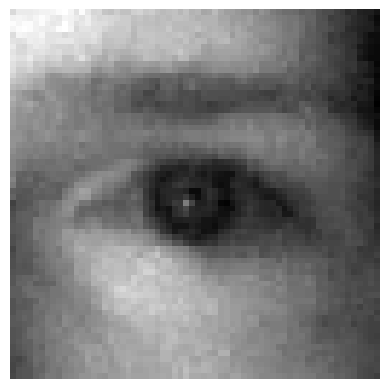

In [4]:
def viz(index, target):
    if target == 0:
        plt.imshow(open_eye_images[index], cmap='gray')
        plt.axis('off')
    elif target == 1: 
        plt.imshow(closed_eye_images[index], cmap = 'gray')
        plt.axis('off')
    else:
        print('Not a valid option, input 0 for open eye and 1 for closed')

viz(6000, 0)

In [5]:
image_generator = ImageDataGenerator(
    rotation_range=20, 
    horizontal_flip=True, 
    shear_range = 0.2, 
    zoom_range = 0.2
)

augmented_images = []
augmented_labels = []
for i in range(len(all_images)):
    img = all_images[i]
    img_label = labels[i]
    img = np.reshape(img, (1, 64, 64, 1))
    aug_iter = image_generator.flow(img, batch_size=1)
    for j in range(3):
        augmented_img = aug_iter.next()[0]
        augmented_img = augmented_img.squeeze()
        augmented_images.append(augmented_img)
        augmented_labels.append(img_label)
        
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

augmented_images.shape



(144000, 64, 64)

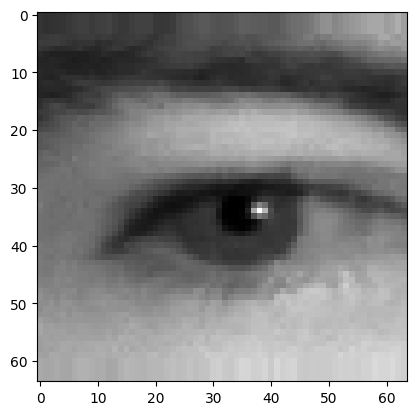

In [6]:
plt.imshow(augmented_images[0], cmap = 'gray')

In [7]:
final_images = np.concatenate((all_images, augmented_images), axis = 0)
final_images = final_images/255
final_images = np.reshape(final_images, (192000, 64, 64, 1))

final_labels = np.concatenate((labels, augmented_labels), axis = 0)


print(final_images.shape, final_labels.shape)

(192000, 64, 64, 1) (192000,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(final_images, final_labels, test_size = 0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(153600, 64, 64, 1) (153600,)
(38400, 64, 64, 1) (38400,)


In [9]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy[1])

Epoch 1/10
4800/4800 [==============================] - 110s 23ms/step - loss: 0.2522 - accuracy: 0.8903 - val_loss: 0.1359 - val_accuracy: 0.9468
Epoch 2/10
4800/4800 [==============================] - 113s 24ms/step - loss: 0.1670 - accuracy: 0.9362 - val_loss: 0.1067 - val_accuracy: 0.9626
Epoch 3/10
4800/4800 [==============================] - 108s 22ms/step - loss: 0.1480 - accuracy: 0.9453 - val_loss: 0.0941 - val_accuracy: 0.9657
Epoch 4/10
4800/4800 [==============================] - 122s 25ms/step - loss: 0.1390 - accuracy: 0.9493 - val_loss: 0.1037 - val_accuracy: 0.9574
Epoch 5/10
4800/4800 [==============================] - 113s 23ms/step - loss: 0.1313 - accuracy: 0.9534 - val_loss: 0.1562 - val_accuracy: 0.9516
Epoch 6/10
4800/4800 [==============================] - 107s 22ms/step - loss: 0.1301 - accuracy: 0.9549 - val_loss: 0.0819 - val_accuracy: 0.9668
Epoch 7/10
4800/4800 [==============================] - 107s 22ms/step - loss: 0.1241 - accuracy: 0.9569 - val_loss: 0

In [14]:
test_image = final_images[0]
test_image = np.reshape(test_image, (1, 64, 64, 1))
model.predict(test_image)

1/1 [==============================] - 0s 97ms/step


array([[0.]], dtype=float32)

In [16]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(final_images, final_labels, epochs=10, batch_size=32)

Epoch 1/10
6000/6000 [==============================] - 126s 21ms/step - loss: 0.2336 - accuracy: 0.9019
Epoch 2/10
6000/6000 [==============================] - 127s 21ms/step - loss: 0.1530 - accuracy: 0.9423
Epoch 3/10
6000/6000 [==============================] - 127s 21ms/step - loss: 0.1361 - accuracy: 0.9508
Epoch 4/10
6000/6000 [==============================] - 139s 23ms/step - loss: 0.1258 - accuracy: 0.9560
Epoch 5/10
6000/6000 [==============================] - 138s 23ms/step - loss: 0.1181 - accuracy: 0.9593
Epoch 6/10
6000/6000 [==============================] - 134s 22ms/step - loss: 0.1157 - accuracy: 0.9607
Epoch 7/10
6000/6000 [==============================] - 132s 22ms/step - loss: 0.1129 - accuracy: 0.9621
Epoch 8/10
6000/6000 [==============================] - 132s 22ms/step - loss: 0.1113 - accuracy: 0.9630
Epoch 9/10
6000/6000 [==============================] - 132s 22ms/step - loss: 0.1082 - accuracy: 0.9633
Epoch 10/10
6000/6000 [==============================] 

In [17]:
model.save('model.keras')

In [19]:
from keras.models import load_model

In [20]:
model2 = load_model('model.keras')

In [25]:
print(np.rint(model2.predict(test_image)))

1/1 [==============================] - 0s 25ms/step
[[0.]]
